<a href="https://colab.research.google.com/github/aliabdelmageed/Weapons-Detection-YOLOv4/blob/master/YOLOv4_to_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/YOLOv4-TF2/

/gdrive/My Drive/yolov4-tf2


In [ ]:
!pip install -r requirements-gpu.txt

# Copy your weight file into data folder

In [ ]:
# Convert darknet weights to tensorflow
!python save_model.py --weights ./data/yolov4-custom.weights --output ./checkpoints/yolov4-custom --input_size 416 --model yolov4 

2020-08-07 11:58:43.387733: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-07 11:58:49.363033: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-07 11:58:49.427404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-07 11:58:49.428066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-08-07 11:58:49.428115: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-07 11:58:49.706132: I tensorflow/stream_executor/platform/default

# Detection using scripts

In [ ]:
#Detect pics
!python detect.py --weights ./checkpoints/yolov4-custom --size 416 --model yolov4 --images ./test/gun2.jpg

In [ ]:
!python detect_video.py --weights ./checkpoints/yolov4-custom --size 416 --model yolov4 --video ./test/gun5.mp4 --output ./detections/results2.mp4

# Load model

In [ ]:
import time
import tensorflow as tf
import core.custom_utils as utils
from core.yolov4 import filter_boxes
from tensorflow.python.saved_model import tag_constants
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.compat.v1 import ConfigProto
%matplotlib inline

In [ ]:
model_size = (416, 416,3)
iou = 0.45
score = 0.25
STRIDES, ANCHORS, NUM_CLASS, XYSCALE = utils.load_config()
input_size = 416
weights = './checkpoints/yolov4-custom'
saved_model_loaded = tf.saved_model.load(weights, tags=[tag_constants.SERVING])

# Detect images

In [ ]:
def detect_img(image_path):

  original_image = cv2.imread(image_path)
  original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

  image_data = cv2.resize(original_image, (input_size, input_size))
  image_data = image_data / 255.

  images_data = []
  for i in range(1):
      images_data.append(image_data)
  images_data = np.asarray(images_data).astype(np.float32)
  infer = saved_model_loaded.signatures['serving_default']
  batch_data = tf.constant(images_data)

  pred_bbox = infer(batch_data)
  for key, value in pred_bbox.items():
      boxes = value[:, :, 0:4]
      pred_conf = value[:, :, 4:]

  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
      boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
      scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
      max_output_size_per_class=50,
      max_total_size=50,
      iou_threshold=iou,
      score_threshold=score)
  
  #draw bbox on org image
  pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
  image = utils.draw_bbox(original_image, pred_bbox)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  detected_img = image_path[:-4] +'-detection'+'.png'
  cv2.imwrite(detected_img, image)
  utils.imShow(detected_img)

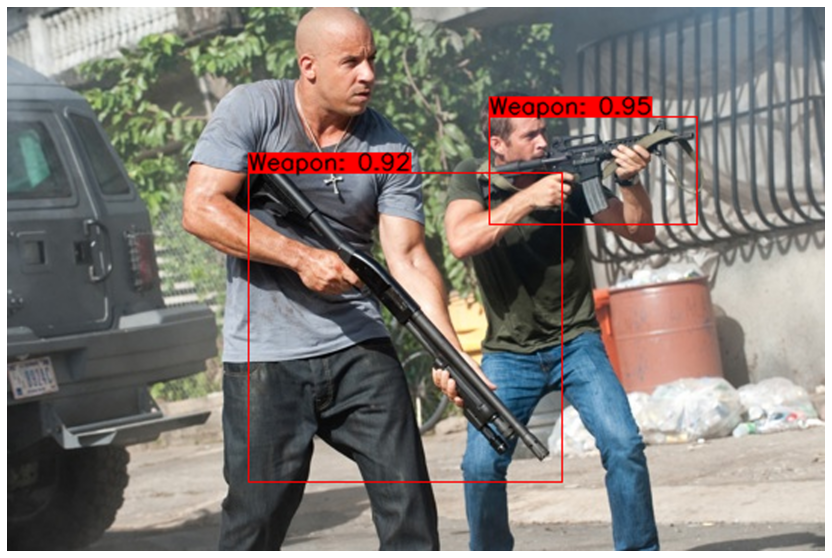

In [ ]:
#detect image
#image_path = utils.upload()
image_path = './test/gun2.jpg'
detect_img(image_path)

#Detect video

In [ ]:
def detect_vid(video_path):
  # begin video capture
  output = video_path[:-4]+"-detection.mp4"
  try:
      vid = cv2.VideoCapture(int(video_path))
  except:
      vid = cv2.VideoCapture(video_path)

  out = None

  # by default VideoCapture returns float instead of int
  fourcc = cv2.VideoWriter_fourcc(*"MJPG")
  width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = int(vid.get(cv2.CAP_PROP_FPS))
  out = cv2.VideoWriter(output, fourcc, fps, (width, height))
  while True:
      return_value, frame = vid.read()
      if return_value:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          image = Image.fromarray(frame)
      else:
          print('Video has ended or failed, try a different video format!')
          break

      frame_size = frame.shape[:2]
      image_data = cv2.resize(frame, (input_size, input_size))
      image_data = image_data / 255.
      image_data = image_data[np.newaxis, ...].astype(np.float32)
      start_time = time.time()
      infer = saved_model_loaded.signatures['serving_default']
      batch_data = tf.constant(image_data)
      pred_bbox = infer(batch_data)
      for key, value in pred_bbox.items():
          boxes = value[:, :, 0:4]
          pred_conf = value[:, :, 4:]

      boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
          boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
          scores=tf.reshape(
              pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
          max_output_size_per_class=50,
          max_total_size=50,
          iou_threshold=iou,
          score_threshold=score
      )
      pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
      image = utils.draw_bbox(frame, pred_bbox)
      fps = 1.0 / (time.time() - start_time)
      print("FPS: %.2f" % fps)
      result = np.asarray(image)
      result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      
      out.write(result)

In [ ]:
vid_path = './test/gun5.mp4'
detect_vid(vid_path)

FPS: 16.32
FPS: 17.26
FPS: 17.07
FPS: 18.48
FPS: 27.08
FPS: 26.74
FPS: 27.50
FPS: 27.39
FPS: 28.74
FPS: 29.37
FPS: 29.43
FPS: 29.36
FPS: 30.06
FPS: 29.40
FPS: 30.15
FPS: 30.20
FPS: 30.46
FPS: 29.92
FPS: 30.10
FPS: 28.52
FPS: 29.67
FPS: 29.54
FPS: 29.56
FPS: 29.19
FPS: 29.13
FPS: 28.53
FPS: 28.37
FPS: 28.88
FPS: 29.68
FPS: 28.90
FPS: 29.33
FPS: 29.33
FPS: 29.37
FPS: 29.24
FPS: 29.39
FPS: 29.39
FPS: 29.28
FPS: 28.52
FPS: 28.76
FPS: 28.73
FPS: 29.18
FPS: 29.92
FPS: 29.97
FPS: 28.24
FPS: 29.83
FPS: 29.70
FPS: 29.88
FPS: 29.70
FPS: 29.15
FPS: 29.28
FPS: 29.10
FPS: 28.57
FPS: 28.90
FPS: 29.39
FPS: 29.16
FPS: 29.34
FPS: 29.81
FPS: 29.98
FPS: 29.78
FPS: 28.03
FPS: 29.33
FPS: 29.26
FPS: 29.48
FPS: 29.50
FPS: 27.62
FPS: 29.07
FPS: 28.52
FPS: 28.18
FPS: 29.62
FPS: 29.57
FPS: 29.39
FPS: 29.64
FPS: 29.44
FPS: 29.33
FPS: 28.32
FPS: 29.08
FPS: 28.67
FPS: 28.86
FPS: 29.12
FPS: 29.60
FPS: 29.20
FPS: 29.52
FPS: 29.62
FPS: 29.73
FPS: 28.41
FPS: 29.51
FPS: 29.68
FPS: 29.01
FPS: 29.73
FPS: 29.30
FPS: 28.22